In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

We perform thresholding on the grayscale image using cv2.threshold(). The THRESH_BINARY_INV flag specifies that we want to invert the binary image, and the THRESH_OTSU flag tells OpenCV to automatically determine the threshold value using Otsu's method. The function returns two values: the threshold value and the resulting binary image.

In [2]:
img = cv2.imread('coins.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

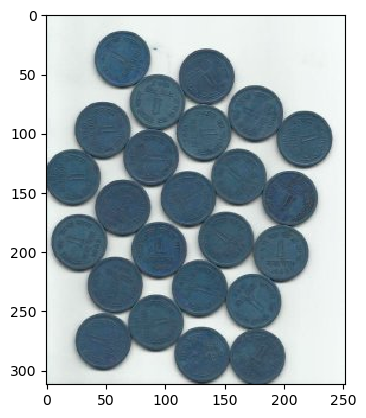

In [3]:
plt.imshow(img, interpolation='nearest')
plt.show()

We define a structuring element kernel as a 3x3 array of ones using numpy.ones(). We then perform morphological opening on the binary image using cv2.morphologyEx(), which removes small objects from the image and smooths the edges. The MORPH_OPEN flag specifies that we want to perform opening, and iterations = 2 specifies the number of times to perform the operation.

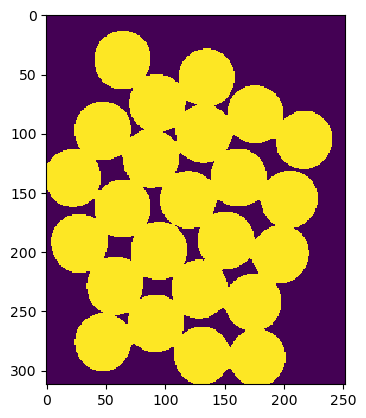

In [4]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

plt.imshow(opening, interpolation='nearest')
plt.show()

We perform dilation on the opened image using cv2.dilate(), which expands the boundaries of the objects in the image. This results in a binary image that contains the sure background areas.

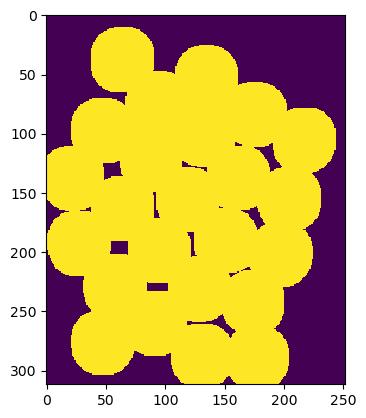

In [5]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

plt.imshow(sure_bg, interpolation='nearest')
plt.show()

We compute the distance transform of the opened image using cv2.distanceTransform(), which calculates the distance of each pixel from the nearest zero pixel. This helps us identify the sure foreground areas. We then apply a threshold to the distance transform image using cv2.threshold(), with a threshold value of 0.7*dist_transform.max(). This converts the image into a binary image where the sure foreground areas are white and the rest is black.

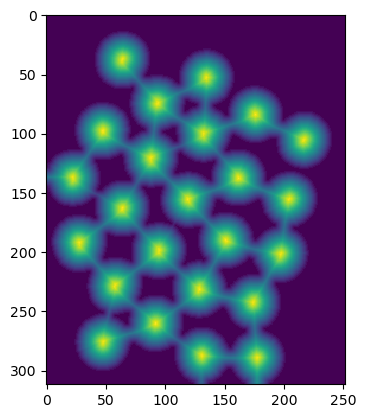

In [6]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

plt.imshow(dist_transform, interpolation='nearest')
plt.show()

We convert the sure foreground image to the uint8 data type using numpy.uint8(). We then subtract the sure foreground image from the sure background image using cv2.subtract(). This results in a binary image that contains the unknown areas.

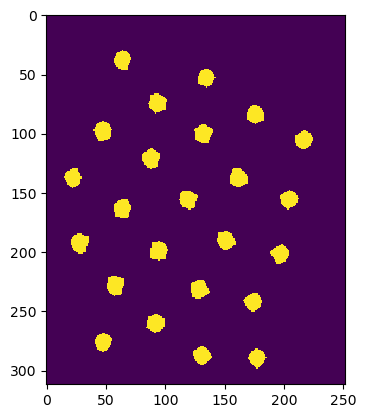

In [7]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

plt.imshow(sure_fg, interpolation='nearest')
plt.show()

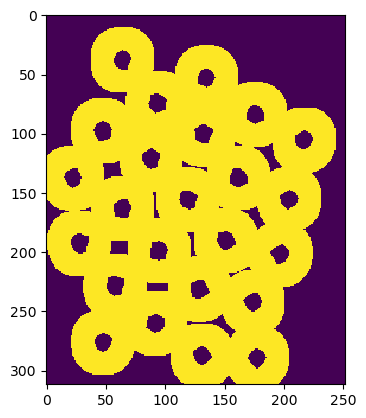

In [8]:
plt.imshow(unknown, interpolation='nearest')
plt.show()

We perform connected components analysis on the sure foreground image using cv2.connectedComponents(). This function labels the connected components in the binary image and returns the number of labels and the labeled image.

Each value in the markers array is incremented by 1. This is done to ensure that the background region is not labeled as 0, which would conflict with the labeling of the foreground regions. By incrementing all the labels by 1, the background is labeled as 1 and the foreground regions are labeled as 2, 3, 4, etc.

The pixels that were previously marked as "unknown" are assigned a value of 0 in the markers array. This is done because the "unknown" region is not part of the foreground or the background, and it needs to be marked as such before the watershed algorithm can be applied.

In [9]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

Applies the watershed algorithm to the image. The img parameter is the input image, and markers is the label matrix that was created in the previous steps. The watershed algorithm uses the markers to segment the image into different regions based on the intensity and texture of the pixels. After the watershed algorithm is applied, the markers matrix contains the final label values for each pixel in the image.

Assigns a blue color to the boundaries of the regions that were segmented by the watershed algorithm. The pixels in the img matrix that have a corresponding value of -1 in the markers matrix are assigned the color [255,0,0], which corresponds to blue in the BGR color space. This highlights the boundaries between the segmented regions in the final output image.

In [10]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

## Marker Image after segmentation:

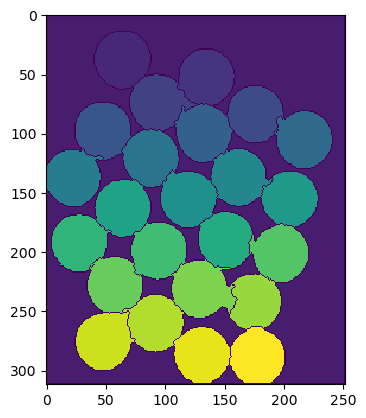

In [11]:
plt.imshow(markers, interpolation='nearest')
plt.show()

## Final Result:

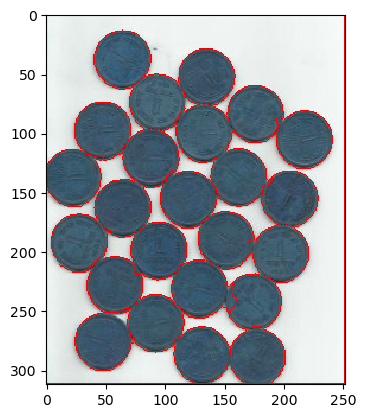

In [12]:
plt.imshow(img, interpolation='nearest')
plt.show()